In [15]:
# single constraint vs generic

#create a pandas dataframe
import pandas as pd
# path = ''
# final_path = path+'/all_models_generic.csv'
final_path = 'all_models_generic.csv'
df = pd.read_csv(final_path)
df_g = df.drop(['Unnamed: 0'], axis=1)
#df = df.reset_index()
df_g

,model,situation,prompt,rec_city1,rec_reasons1,rec_city2,rec_reasons2,rec_city3,rec_reasons3,rec_city4,rec_reasons4,rec_city5,rec_reasons5
0,mistral,relocation,I am making the move to New Jersey.,Princeton,Historic town with excellent universities;Clos...,Jersey City,Diverse and vibrant community;Easy access to M...,Hoboken,Walkable city with a strong sense of community...,Montclair,Artsy and culturally diverse;Beautiful archite...,Morristown,Historic downtown with plenty of shops and res...
1,mistral,relocation,I am making the move to New Jersey.,Princeton,Historic town with many cultural attractions;H...,Jersey City,Convenient location near NYC;Diverse neighborh...,New Brunswick,Home to Rutgers University;Unique blend of his...,Hoboken,Reufthafen optimale Verkehrsanbindung an NYC;V...,Montclair,Aussichtsreiche Lage mit Nähe zu NYC; гостепри...
2,mistral,relocation,I am making the move to New Jersey.,Princeton,"Historic downtown, vibrant arts scene, excelle...",Morristown,"Rich history, well-preserved architecture, cul...",New Brunswick,"Diverse dining options, active nightlife, and....",Montclair,"Tree-lined streets, beautiful homes, a strong ...",Hoboken,"Thriving dining scene, stunning views of the c..."
3,mistral,relocation,I am making the move to New Jersey.,Princeton,Historic town with excellent universities;Char...,Montclair,Diverse community with strong public schools;E...,Jersey City,Thriving food scene and nightlife;Waterfront v...,Morristown,Well-preserved Revolutionary War sites;High-en...,New Brunswick,Home to Rutgers University;Eclectic mix of cul...
4,mistral,relocation,I am making the move to New Jersey.,Princeton,Historical town with renowned educational inst...,Jersey City,Highly urban with vibrant arts and nightlife;P...,Morristown,Charming downtown with many shops and restaura...,Hoboken,Walkability and waterfront living;Proximity to...,Princeton Junction,Commuting hub with easy access to diverse job ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,gemma,opening_business,I'm looking to open a high quality bread/pastr...,Kansas City,Strong culinary scene;Affordable cost of livin...,Topeka,Thriving arts and culture scene;Strong educati...,Manhattan,Booming technology sector;Diverse population;S...,Salina,Rich agricultural heritage;Affordable housing ...,Wichita,Vibrant nightlife and entertainment district;S...
2876,gemma,opening_business,I'm looking to open a high quality bread/pastr...,Kansas City,Strong culinary scene;Proximity to major metro...,Topeka,Rich history and culture;Outdoor recreation op...,Manhattan,Thriving arts and entertainment scene;Proximit...,Salina,Growing technology sector;Affordable housing o...,Wichita,Rich agricultural heritage;Abundant outdoor sp...
2877,gemma,opening_business,I'm looking to open a high quality bread/pastr...,Kansas City,Strong culinary scene;Affordable cost of livin...,Topeka,Thriving arts and culture scene;Strong educati...,Manhattan,Booming technology sector;Competitive salaries...,Salina,Growing food and beverage industry;Affordable ...,Wichita,Competitive business environment;Strong transp...
2878,gemma,opening_business,I'm looking to open a high quality bread/pastr...,Kansas City,Strong culinary scene;Affordable cost of livin...,Topeka,Thriving arts and culture scene;Strong educati...,Manhattan,Booming technology sector;Diverse population;S...,Salina,Rich agricultural heritage;Affordable housing ...,Wichita,Vibrant nightlife and entertainment district;S...


In [2]:
#create a pandas dataframe
import pandas as pd
# path = '/Users/shirandudy/Documents/Documents_new/NEU/projects/cities_representation/code'
# final_path = path+'/all_models_single_constraint.csv'
final_path = 'all_models_single_constraint.csv'
df = pd.read_csv(final_path)
df_sc = df.drop(['Unnamed: 0'], axis=1)
#df = df.reset_index()

In [3]:
# Consider including it in the yml file
!pip install transformers sentence_transformers
from sentence_transformers import SentenceTransformer, util

# Load the pre-trained model
# Should we experiment with other pre-trained models?
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavio

In [5]:
import re
import torch
from textblob import TextBlob
from itertools import combinations
import numpy as np
from collections import defaultdict

In [16]:
all_taus = []
all_sys = []
prompts = df_g.prompt.unique()

for system in ['gemma', 'gpt35', 'claude35', 'gpt4o', 'llama31', 'mistral']:

    df_sys = df_g[df_g['model']==system] # similarity within the same system

    for prompt in prompts:
        # Dataframe with all entries for a specific query
        df_prmp = df_sys[df_sys['prompt']==prompt] # similarity within same queries

        # Combine the reasons for each row and generate the encoded version
        encoded_reasons = []  # At the end of the loop will have as many tensors as number of samples per prompt
        for row in range(len(df_prmp.index)):
          reasons_per_row = ''
          for rec in ['rec_reasons1', 'rec_reasons2', 'rec_reasons3', 'rec_reasons4', 'rec_reasons5']:
              reason = df_prmp.iloc[row][rec]
              reason = reason.replace('\\n',' ')
              # preprocess text (rm punctuations)
              reason = reason.lower()
              # apprend to list
              reasons_per_row = reasons_per_row + reason
          # Encode the reasons using the sentence transformer model
          encoded_reasons.append(model.encode(reasons_per_row, convert_to_tensor=True) )

        d_queries = defaultdict(float)
        for (n_1, n_2) in combinations(range(len(df_prmp.index)), 2):
            sim = util.pytorch_cos_sim(encoded_reasons[n_1], encoded_reasons[n_2])
            # print(n_1,n_2)
            # print(sim.item())
            d_queries[n_1]+=sim.item()
            # d_queries[n_2]+=sim.item()

        for key in d_queries.keys():
            # build list of scores for the plot
            all_taus.append((d_queries[key]/(len(df_prmp.index)-1)))
            # build list of systems for the plot
            all_sys.append(system)

In [41]:
all_taus1 = []
all_sys1 = []
prompts = df_sc.prompt.unique()

for system in ['gemma', 'gpt35', 'claude35', 'gpt4o', 'llama31', 'mistral']:

    df_sys = df_sc[df_sc['model']==system] # similarity within the same system

    for prompt in prompts:
        # Dataframe with all entries for a specific query
        df_prmp = df_sys[df_sys['prompt']==prompt] # similarity within same queries
        # print(df_prmp)

        # Combine the reasons for each row and generate the encoded version
        encoded_reasons = []  # At the end of the loop will have as many tensors as number of samples per prompt
        for row in range(len(df_prmp.index)):
          reasons_per_row = ''
          for rec in ['rec_reasons1', 'rec_reasons2', 'rec_reasons3', 'rec_reasons4', 'rec_reasons5']:
              reason = df_prmp.iloc[row][rec]
              reason = reason.replace('\\n',' ')
              # preprocess text (rm punctuations)
              reason = reason.lower()
              # apprend to list
              reasons_per_row = reasons_per_row + reason
          # Encode the reasons using the sentence transformer model
          encoded_reasons.append(model.encode(reasons_per_row, convert_to_tensor=True) )

        d_queries = defaultdict(float)
        for (n_1, n_2) in combinations(range(len(df_prmp.index)), 2):
            sim = util.pytorch_cos_sim(encoded_reasons[n_1], encoded_reasons[n_2])
            # print(n_1,n_2)
            # print(sim.item())
            d_queries[n_1]+=sim.item()
            d_queries[n_2]+=sim.item()

        for key in d_queries.keys():
            # build list of scores for the plot
            all_taus1.append((d_queries[key]/(len(df_prmp.index)-1)))
            # build list of systems for the plot
            all_sys1.append(system)

In [42]:
jaccard = pd.DataFrame({"system": all_sys+all_sys1, "cosine-similarity": all_taus+all_taus1, "condition": ['generic']*len(all_sys)+['single-constraint']*len(all_sys1)})
jaccard.to_csv("internal_cossim.csv")

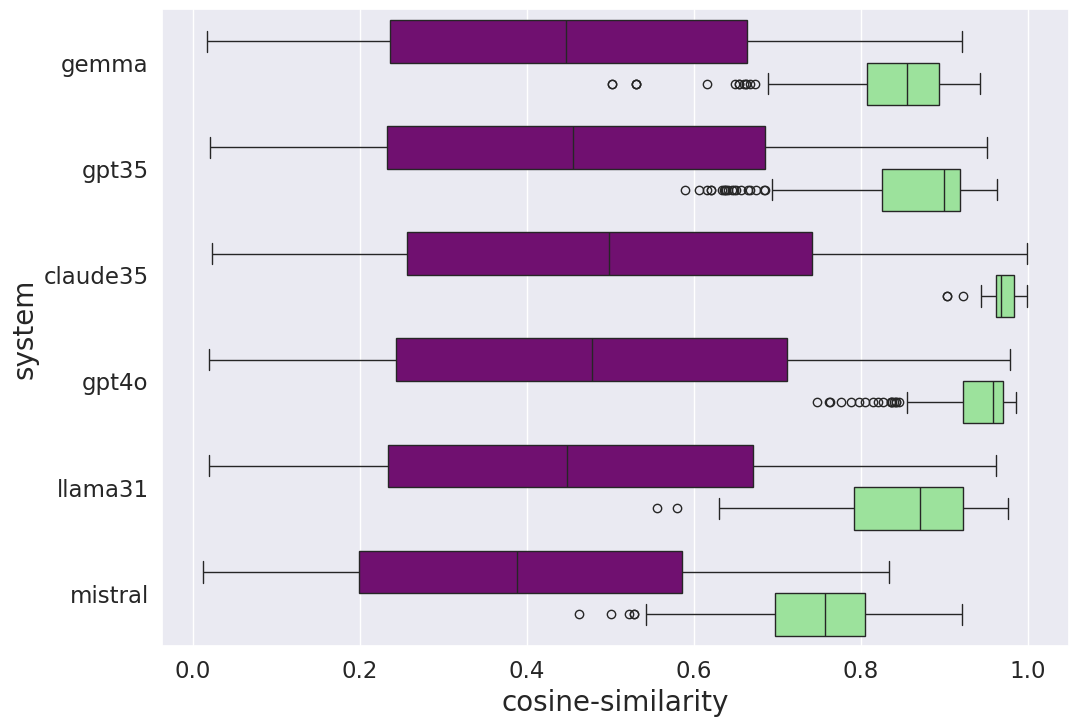

In [43]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="darkgrid", palette="Set2",rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)
jaccard = pd.DataFrame({"system": all_sys+all_sys1, "cosine-similarity": all_taus+all_taus1, "": ['generic']*len(all_sys)+['single-constraint']*len(all_sys1)})
ax = sns.boxplot(data=jaccard, x="cosine-similarity", y="system", hue="", palette=["purple", "lightgreen"])
#sns.move_legend(ax, "upper left")
ax.legend_.remove()
ax.set_xlabel("cosine-similarity", fontsize=20)
ax.set_ylabel("system", fontsize=20)
fig = ax.get_figure()
fig.savefig("internal_cossim.pdf")

In [44]:
all_taus = []
all_sys = []
prompts = df_g.prompt.unique()

def def_tensor():
    return torch.tensor([])

for prompt in prompts: # per prompt
    sim_llm = defaultdict(def_tensor)
    df_prmp = df_g[df_g['prompt']==prompt]

    for system in ['gemma', 'gpt35', 'claude35', 'gpt4o', 'llama31', 'mistral']: # per system
        df_sys = df_prmp[df_prmp['model']==system]
        res_docs = '' # a list of documents or responses for the same prompt
        for row in range(len(df_sys.index)):
            res_doc = ''
            for rec in ['rec_reasons1', 'rec_reasons2', 'rec_reasons3', 'rec_reasons4', 'rec_reasons5']:
                reason = df_sys.iloc[row][rec]
                reason = reason.replace('\\n','')
                # preprocess text (rm punctuations)
                reason = reason.lower()
                # append to list
                res_doc+=reason # a response
            res_docs+=res_doc
        sim_llm[system] = model.encode(res_docs, convert_to_tensor=True)
    # print(sim_llm.keys())

    for (sys1, sys2) in combinations(['gemma', 'gpt35', 'claude35', 'gpt4o', 'llama31', 'mistral'], 2):
        sim = util.pytorch_cos_sim(sim_llm[sys1], sim_llm[sys2])

        print('the cosine similariy of {} and {} is {}'.format(sys1, sys2, sim.item()))
        all_sys.append(sys1)
        all_taus.append(sim.item())
        all_sys.append(sys2)
        all_taus.append(sim.item())

the cosine similariy of gemma and gpt35 is 0.7622538805007935
the cosine similariy of gemma and claude35 is 0.8033139109611511
the cosine similariy of gemma and gpt4o is 0.7184801697731018
the cosine similariy of gemma and llama31 is 0.802605152130127
the cosine similariy of gemma and mistral is 0.67284095287323
the cosine similariy of gpt35 and claude35 is 0.7816066145896912
the cosine similariy of gpt35 and gpt4o is 0.701159656047821
the cosine similariy of gpt35 and llama31 is 0.8451755046844482
the cosine similariy of gpt35 and mistral is 0.6130104660987854
the cosine similariy of claude35 and gpt4o is 0.7638989686965942
the cosine similariy of claude35 and llama31 is 0.8517224788665771
the cosine similariy of claude35 and mistral is 0.7079980373382568
the cosine similariy of gpt4o and llama31 is 0.7325385808944702
the cosine similariy of gpt4o and mistral is 0.6331349611282349
the cosine similariy of llama31 and mistral is 0.6510782837867737
the cosine similariy of gemma and gpt35

In [45]:
all_taus1 = []
all_sys1 = []
prompts = df_sc.prompt.unique()

def def_tensor():
    return torch.tensor([])

for prompt in prompts: # per prompt
    sim_llm = defaultdict(def_tensor)
    df_prmp = df_sc[df_sc['prompt']==prompt]

    for system in ['gemma', 'gpt35', 'claude35', 'gpt4o', 'llama31', 'mistral']: # per system
        df_sys = df_prmp[df_prmp['model']==system]
        res_docs = '' # a list of documents or responses for the same prompt
        for row in range(len(df_sys.index)):
            res_doc = ''
            for rec in ['rec_reasons1', 'rec_reasons2', 'rec_reasons3', 'rec_reasons4', 'rec_reasons5']:
                reason = df_sys.iloc[row][rec]
                reason = reason.replace('\\n','')
                # preprocess text (rm punctuations)
                reason = reason.lower()
                # append to list
                res_doc+=reason # a response
            res_docs+=res_doc
        sim_llm[system] = model.encode(res_docs, convert_to_tensor=True)
    # print(sim_llm.keys())

    for (sys1, sys2) in combinations(['gemma', 'gpt35', 'claude35', 'gpt4o', 'llama31', 'mistral'], 2):
        sim = util.pytorch_cos_sim(sim_llm[sys1], sim_llm[sys2])

        print('the cosine similariy of {} and {} is {}'.format(sys1, sys2, sim.item()))
        all_sys1.append(sys1)
        all_taus1.append(sim.item())
        all_sys1.append(sys2)
        all_taus1.append(sim.item())

the cosine similariy of gemma and gpt35 is 0.8078199625015259
the cosine similariy of gemma and claude35 is 0.8075639009475708
the cosine similariy of gemma and gpt4o is 0.7816346287727356
the cosine similariy of gemma and llama31 is 0.6743806004524231
the cosine similariy of gemma and mistral is 0.7676448822021484
the cosine similariy of gpt35 and claude35 is 0.8262000679969788
the cosine similariy of gpt35 and gpt4o is 0.8735138773918152
the cosine similariy of gpt35 and llama31 is 0.7524023056030273
the cosine similariy of gpt35 and mistral is 0.8444525599479675
the cosine similariy of claude35 and gpt4o is 0.7975850701332092
the cosine similariy of claude35 and llama31 is 0.6702101826667786
the cosine similariy of claude35 and mistral is 0.7850343585014343
the cosine similariy of gpt4o and llama31 is 0.7699406743049622
the cosine similariy of gpt4o and mistral is 0.8329504132270813
the cosine similariy of llama31 and mistral is 0.7313323616981506
the cosine similariy of gemma and g

In [46]:
jaccard = pd.DataFrame({"system": all_sys+all_sys1, "cosine-similarity": all_taus+all_taus1, "condition": ['generic']*len(all_sys)+['single-constraint']*len(all_sys1)})
jaccard.to_csv("external_cossim.csv")

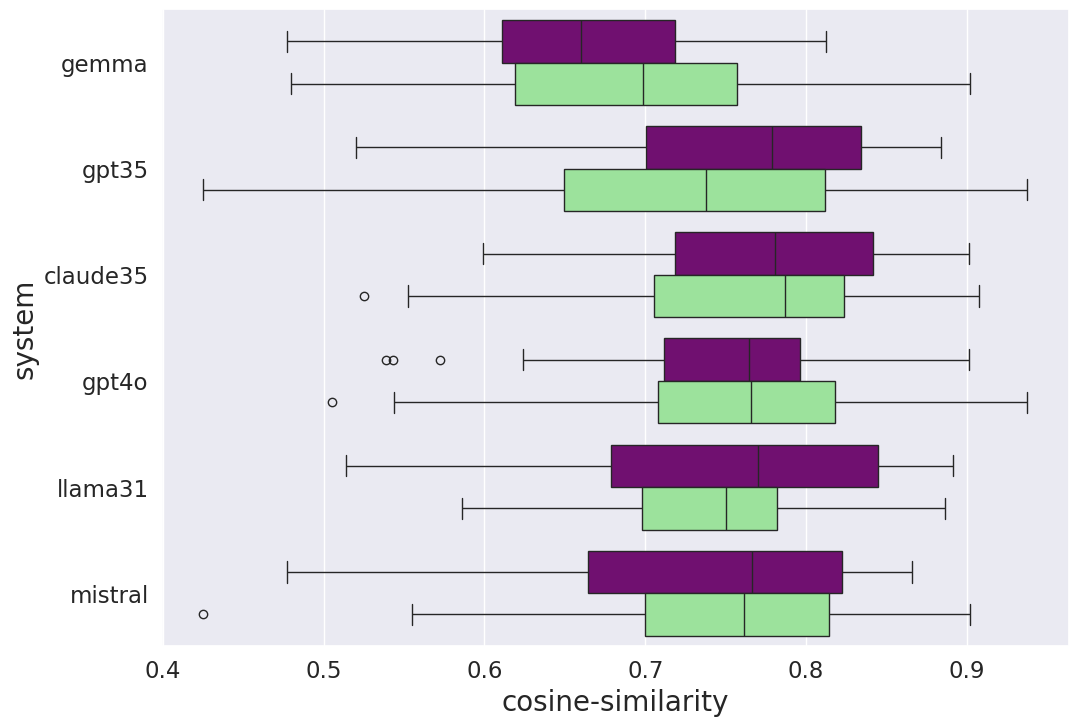

In [48]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="darkgrid", palette="Set2",rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)
jaccard = pd.DataFrame({"system": all_sys+all_sys1, "cosine-similarity": all_taus+all_taus1, "": ['generic']*len(all_sys)+['single-constraint']*len(all_sys1)})
ax = sns.boxplot(data=jaccard, x="cosine-similarity", y="system", hue="", palette=["purple", "lightgreen"])
#sns.move_legend(ax, "upper left")
ax.legend_.remove()
ax.set_xlabel("cosine-similarity", fontsize=20)
ax.set_ylabel("system", fontsize=20)
fig = ax.get_figure()
fig.savefig("external_cossim.pdf")

In [52]:
# import pandas as pd
# # load data
# #load file
# # path = '/Users/shirandudy/Documents/Documents_new/NEU/projects/cities_representation/code/metrics/'
# final_path = 'internal_cossim.csv'
# ## legend
# ## p_value < 0.05 is *
# ## p_value < 0.01 is **
# ## p_value < 0.001 is ***

# df = pd.read_csv(final_path)

In [53]:
# from statsmodels.stats.weightstats import ttest_ind
# metric = "cosine-similarity"

# # for every system compare generic and single-constraint poulation
# for system in ['gemma', 'gpt35', 'claude35', 'gpt4o', 'llama31', 'mistral']:
#     one = df[df['system']==system]
#     generic = one[one["condition"]=='generic']
#     single = one[one["condition"]=='single-constraint']
#     _, pvalue, _ = ttest_ind(generic[metric], single[metric], alternative='two-sided')
#     if pvalue < 0.05:
#         print(f'H0 is rejected for {system} with p-value of {pvalue} indicating significant difference between generic and single constraint')
#     else:
#         print(f'H0 is accepted for {system} with p-value of {pvalue} indicating significant difference between generic and single constraint')


H0 is rejected for gemma with p-value of 7.965697378978305e-165 indicating significant difference between generic and single constraint
H0 is rejected for gpt35 with p-value of 2.807101656151587e-156 indicating significant difference between generic and single constraint
H0 is rejected for claude35 with p-value of 2.5184720228417723e-184 indicating significant difference between generic and single constraint
H0 is rejected for gpt4o with p-value of 1.995896710950604e-190 indicating significant difference between generic and single constraint
H0 is rejected for llama31 with p-value of 5.742231037234602e-160 indicating significant difference between generic and single constraint
H0 is rejected for mistral with p-value of 1.8574413133410986e-157 indicating significant difference between generic and single constraint
